In [24]:
from model.classification_model import ClassifierModel # class with classifiers
from model.reduce_model import ReduceModel # class with autoencoder

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from plot_settings import * # plot configuration 

ide_plot() #plot for github dark theme

In [28]:
# Load main dataset
dataset = pd.read_csv("main_datasets/dataset.csv", index_col=0)
target = pd.read_csv("main_datasets/target.csv", index_col=0)

In [3]:
reduce_model = ReduceModel(model="AE", layers=(dataset.shape[1], 300, 10))
reduce_model.train(epochs=100, lr=1e-3)

100%|██████████| 100/100 [00:40<00:00,  2.48it/s]

Epoch 100, Train Loss: 0.0013965970930702827
Epoch 100, Validation Loss: 0.001439928824159627


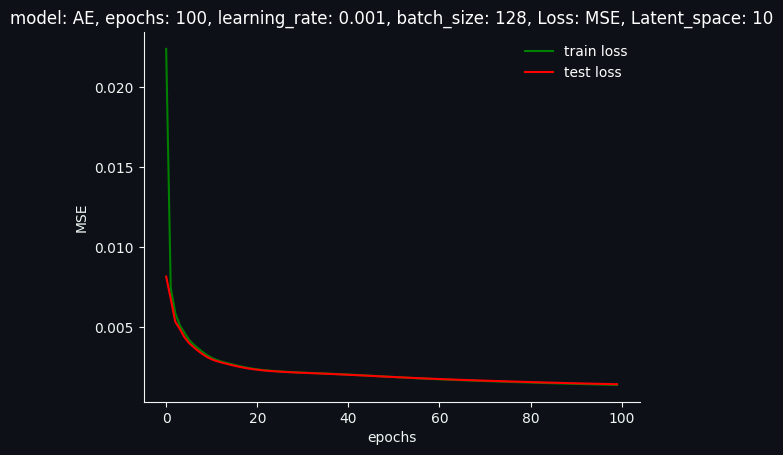

In [4]:
reduce_model.plot_loss()


In [5]:
main_reduced = reduce_model.transform(dataset)

In [6]:
qmof_reduced = reduce_model.transform(reduce_model.dataset.cpu())

In [7]:
main_reduced.shape

(102, 10)

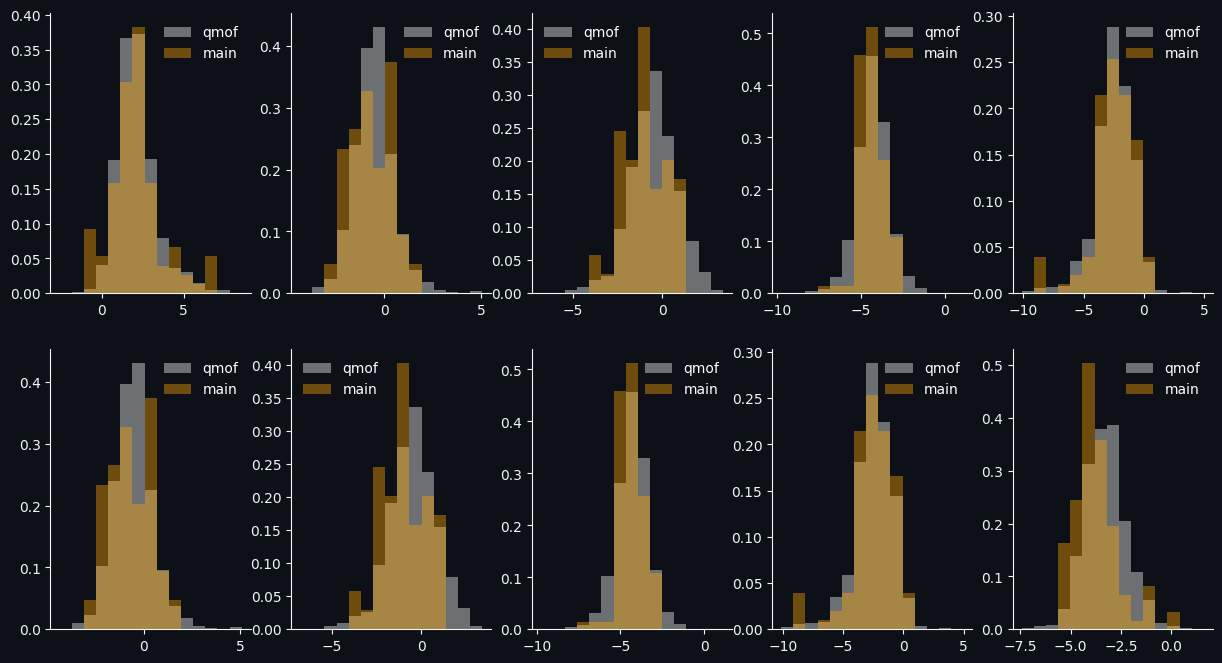

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(15,8))
u = 0
for i in range(2):
    for h in range(5):
        v, bins, p = axes[i,h].hist(qmof_reduced[:, u], density=True, bins=15, alpha=0.4, label="qmof", color='w')
        axes[i,h].hist(main_reduced[:, u], density=True, bins=bins, alpha=0.4, label="main", color='orange')
        axes[i,h].legend()
        u += 1
        


In [9]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer


def plot_2d(x1, y1, name):
    x1 = Normalizer().transform(x1)
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    pca = PCA(n_components=2, random_state=0)
    X_p = pca.fit_transform(x1)

    ax1.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='0')
    ax1.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='1')
    ax1.set_title(f"TSNE: {name}")

    ax2.scatter(X_p[np.where(y1 == 0), 0], X_p[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='0')
    ax2.scatter(X_p[np.where(y1 == 1), 0], X_p[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='1')
    ax2.set_title(f"PCA: {name}")
    ax2.legend()

def plot_2d_proba(x1, y1_proba, name):
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    pca = PCA(n_components=2, random_state=0)
    X_p = pca.fit_transform(x1)

    ax1.scatter(X_t[:, 0], X_t[:, 1], marker='o', color=y1_proba, linewidth=1, alpha=0.8, label='0')
    ax1.set_title(f"TSNE: {name}")

    ax2.scatter(X_p[:, 0], X_p[:, 1], marker='o', color=y1_proba, linewidth=1, alpha=0.8, label='0')
    ax2.set_title(f"PCA: {name}")
    ax2.legend()

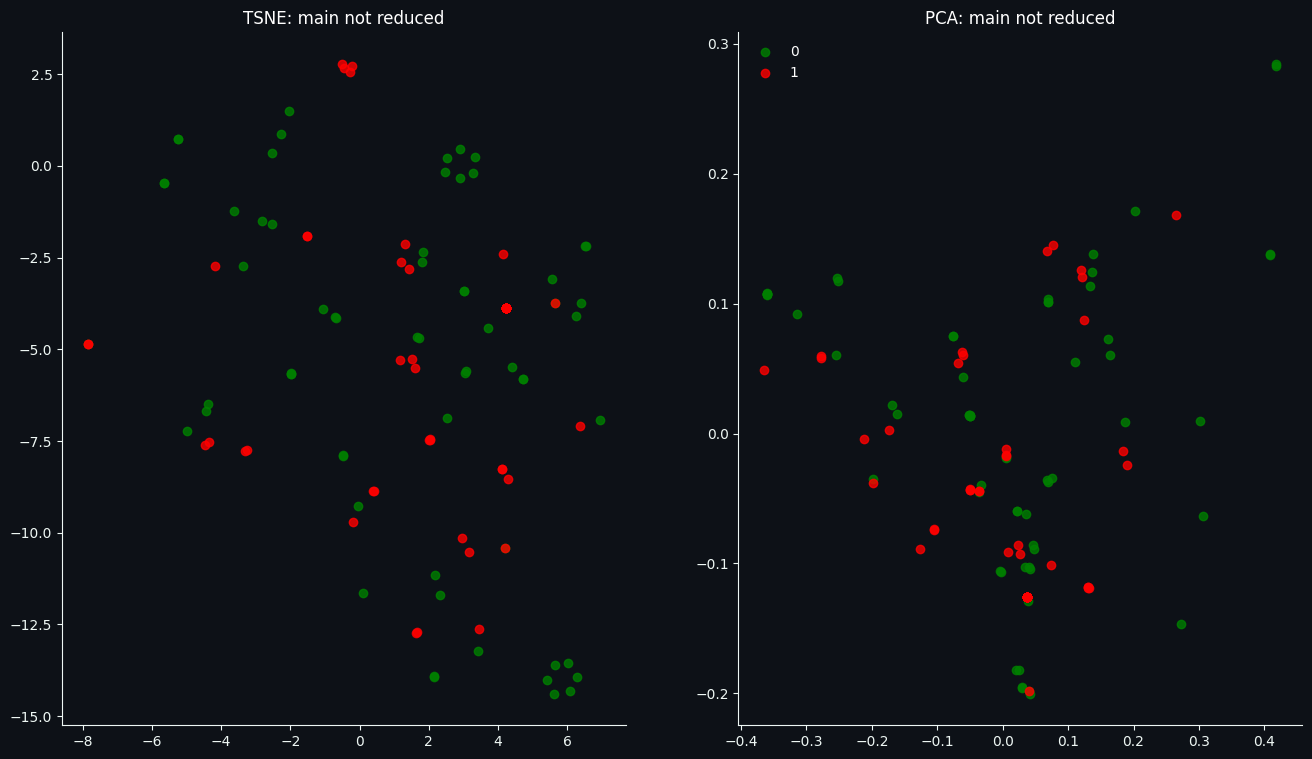

In [10]:
plot_2d(dataset.values, target, "main not reduced")

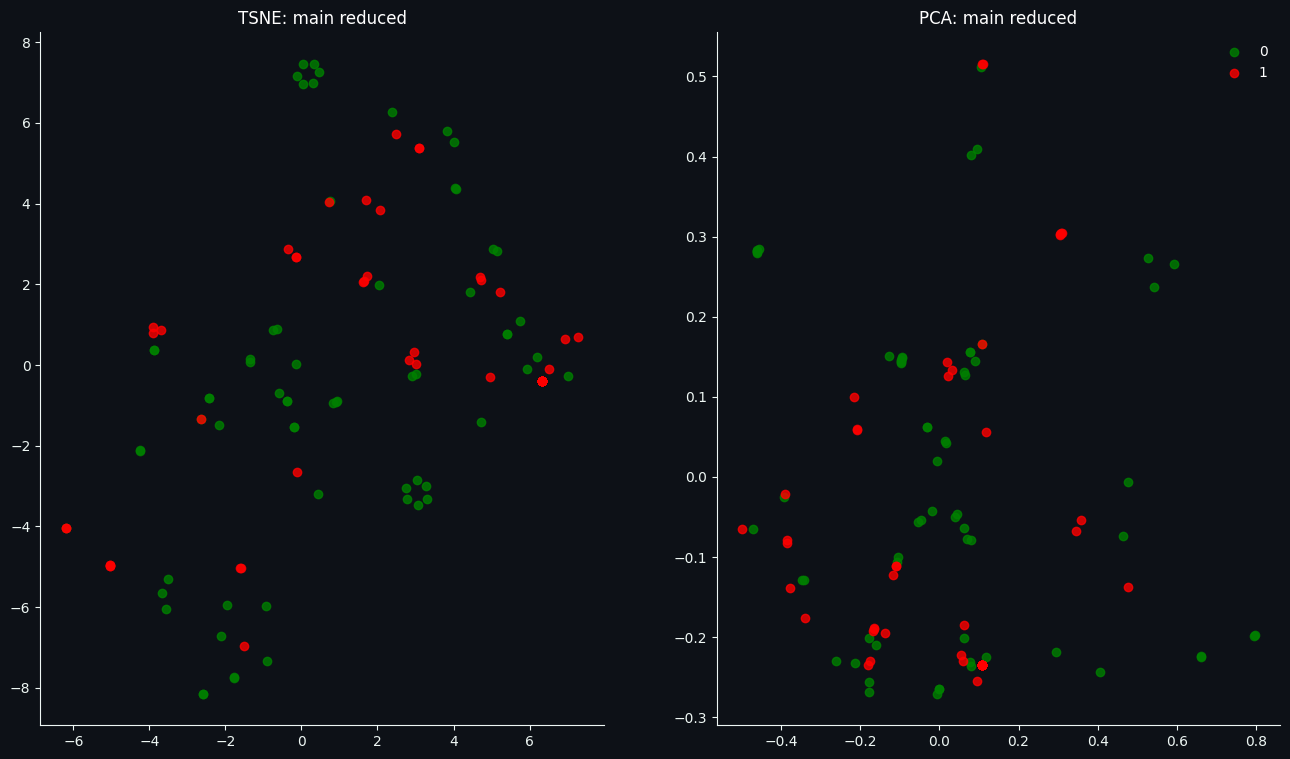

In [11]:
plot_2d(main_reduced, target, "main reduced")

In [12]:
plot_2d(reduce_model.dataset.cpu(), np.zeros((reduce_model.dataset.cpu().shape[0])), "qmof no reduce")

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

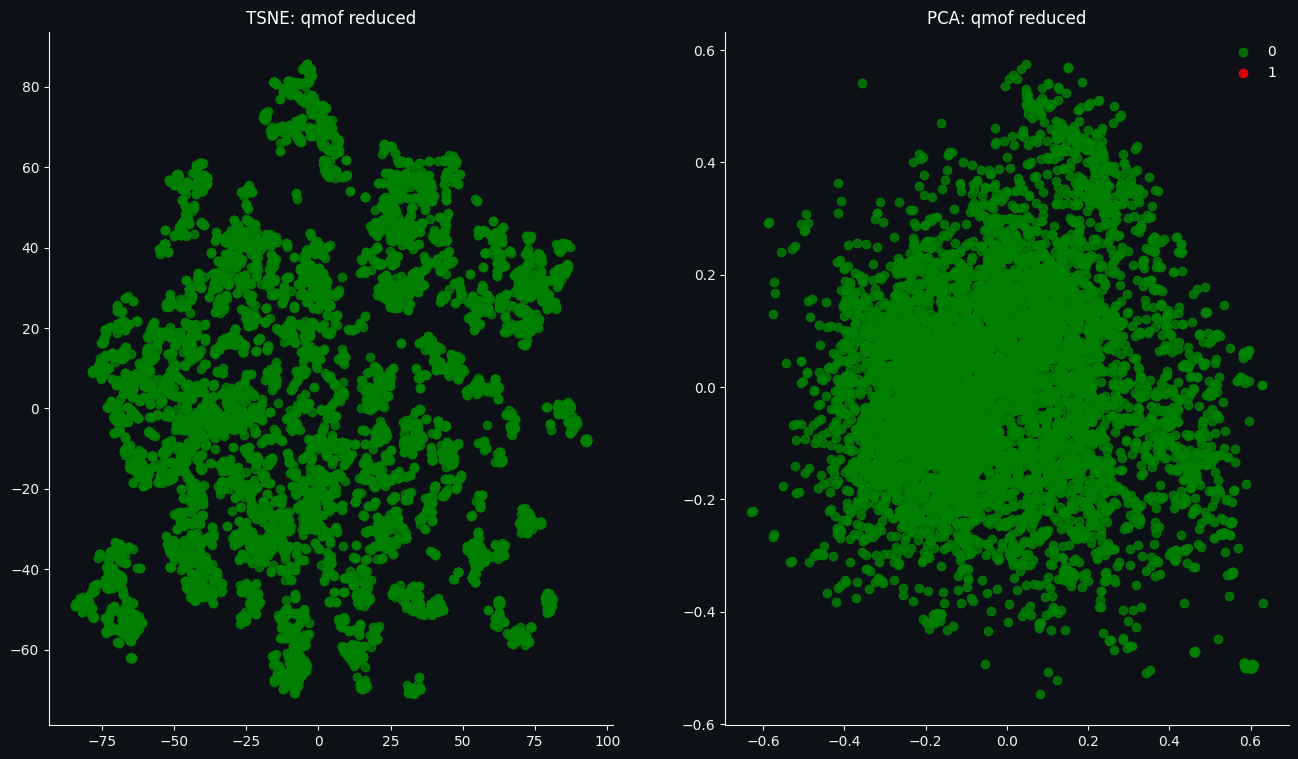

In [13]:
plot_2d(qmof_reduced, np.zeros((qmof_reduced.shape[0],)), "qmof reduced")

# Classification

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    main_reduced, target.values.ravel(), test_size=0.2, random_state=42,
    stratify=target.values.ravel()
    )

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
qmof_reduced_scaled = scaler.transform(qmof_reduced)

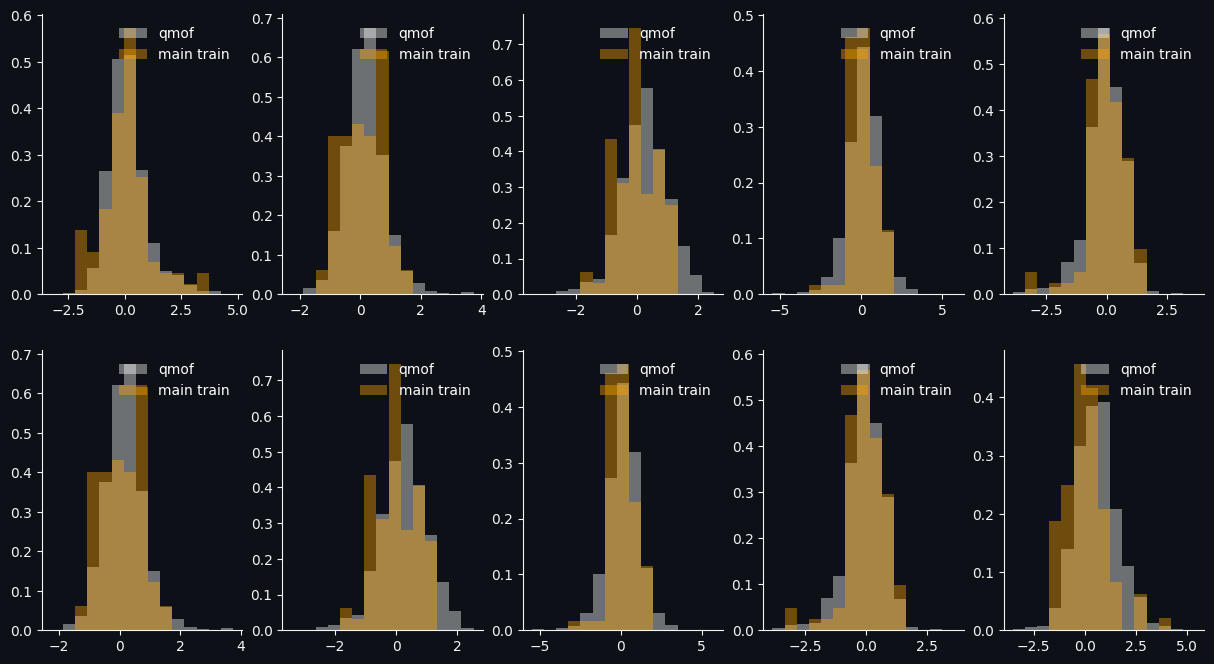

In [15]:
fig, axes = plt.subplots(2, 5, figsize=(15,8))
u=0
for i in range(2):
    for j in range(5):
        v, bins, p = axes[i,j].hist(qmof_reduced_scaled[:, u], density=True, bins=15, alpha=0.4, label="qmof", color='w')
        axes[i,j].hist(X_train[:, u], density=True, bins=bins, alpha=0.4, label="main train", color='orange')
        axes[i,j].legend()
        u+=1

In [16]:
c_model = ClassifierModel()
res = c_model.cv(pd.DataFrame(X_train), pd.DataFrame(y_train), time_per_clf=10)

evaluate CatBoost
  0%|          | 0/9223372036854775807 [00:00<?, ?trial/s, best loss=?]

  0%|          | 31/9223372036854775807 [00:10<874482996744624:46:56,  2.93trial/s, best loss: -0.9226190476190477] 
best depth ber folds: [8, 10, 9, 12, 12]
best n_estimators ber folds: [60, 42, 30, 59, 34]
best learning_rate ber folds: [0.00067618181074734, 4.884488007805756e-05, 0.0003163636250355746, 6.375976496509017e-05, 8.28505882627623e-05]
best l2_leaf_reg ber folds: [0.34917675854966146, 0.013168541774103981, 0.11090726782703715, 0.08773238200274666, 0.17945777844828428]
evaluate RF
  0%|          | 77/9223372036854775807 [00:10<336202596808334:47:28,  7.62trial/s, best loss: -0.8340909090909092]
best max_depth ber folds: [11, 17, 15, 20, 19]
best n_estimators ber folds: [71, 53, 46, 40, 99]
evaluate AdaBoost
  0%|          | 82/9223372036854775807 [00:10<315325788690457:57:20,  8.13trial/s, best loss: -0.8340909090909092]
best max_depth ber folds: [12, 6, 10, 6, 11]
best n_estimators ber folds: [46, 40, 52, 52, 44]
best learning_rate ber folds: [2.227450022699522e-05, 0.0002

In [17]:
res

{'CatBoost': {'depth': 12,
  'l2_leaf_reg': 0.17945777844828428,
  'learning_rate': 8.28505882627623e-05,
  'n_estimators': 34,
  'score': 0.9226190476190477,
  'balance': {'test': {'0.0': 11, '1.0': 5}, 'train': {'0.0': 41, '1.0': 24}}},
 'RF': {'max_depth': 19,
  'n_estimators': 99,
  'score': 0.8340909090909092,
  'balance': {'test': {'0.0': 11, '1.0': 5}, 'train': {'0.0': 41, '1.0': 24}}},
 'AdaBoost': {'learning_rate': 0.0007956231402920171,
  'max_depth': 11,
  'n_estimators': 44,
  'score': 0.8340909090909092,
  'balance': {'test': {'0.0': 11, '1.0': 5}, 'train': {'0.0': 41, '1.0': 24}}},
 'Knn': {'n_neighbors': 4,
  'score': 0.9253246753246753,
  'balance': {'test': {'0.0': 10, '1.0': 6}, 'train': {'0.0': 42, '1.0': 23}}}}

In [18]:
c_model.set_params({name: {param: res[name][param] for param in res[name] if param not in (
    "balance", "score")} for name in res})
c_model.fit(X_train, y_train)

In [19]:
for name in c_model.models:
    pred = c_model.models[name].predict(X_test)
    print(f"report for {name}: {c_model.score(y_test, pred):.2f}")
    print(metrics.classification_report(y_test, pred))

report for CatBoost: 0.80
              precision    recall  f1-score   support

         0.0       0.91      0.77      0.83        13
         1.0       0.70      0.88      0.78         8

    accuracy                           0.81        21
   macro avg       0.80      0.82      0.81        21
weighted avg       0.83      0.81      0.81        21

report for RF: 0.81
              precision    recall  f1-score   support

         0.0       1.00      0.69      0.82        13
         1.0       0.67      1.00      0.80         8

    accuracy                           0.81        21
   macro avg       0.83      0.85      0.81        21
weighted avg       0.87      0.81      0.81        21

report for XGB: 0.60
              precision    recall  f1-score   support

         0.0       0.73      0.62      0.67        13
         1.0       0.50      0.62      0.56         8

    accuracy                           0.62        21
   macro avg       0.61      0.62      0.61        21
weighte

c:\Users\v.shirobokov\.conda\envs\phase_trans_ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\v.shirobokov\.conda\envs\phase_trans_ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\v.shirobokov\.conda\envs\phase_trans_ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [20]:
def roc_auc_plot(clf_model: ClassifierModel, x_test, y_test):
    plt.figure()
    lw = 2
    plt.plot()
    for clf in clf_model.models:
        pred_proba = clf_model.models[clf].predict_proba(x_test)
        fpr, tpr, threshold = metrics.roc_curve(y_test, pred_proba[:,1])
        auc = metrics.auc(fpr, tpr)
        plt.plot(fpr,
                 tpr,
                 label=f"ROC curve {clf} (area={auc:.2f})")
    plt.plot([0, 1], [0, 1], color="orange", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

def roc_auc_plot_one(clf: object, x_test, y_test):
    plt.figure()
    lw = 2
    plt.plot()
    pred_proba = clf.predict_proba(x_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test, pred_proba[:,1])
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label=f"ROC curve: (area={auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

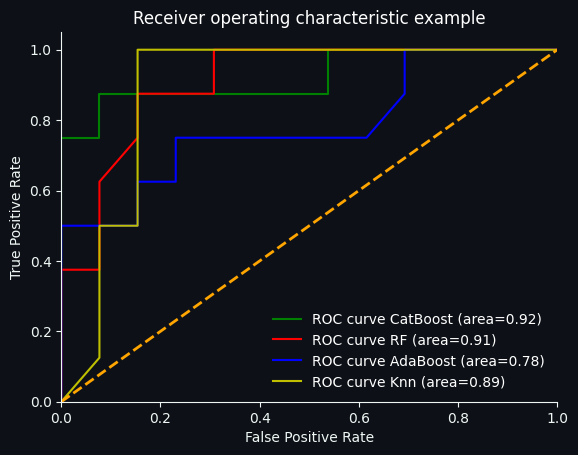

In [21]:
roc_auc_plot(c_model, X_test, y_test)

In [22]:
qmof_reduced = reduce_model.transform(reduce_model.dataset.cpu())

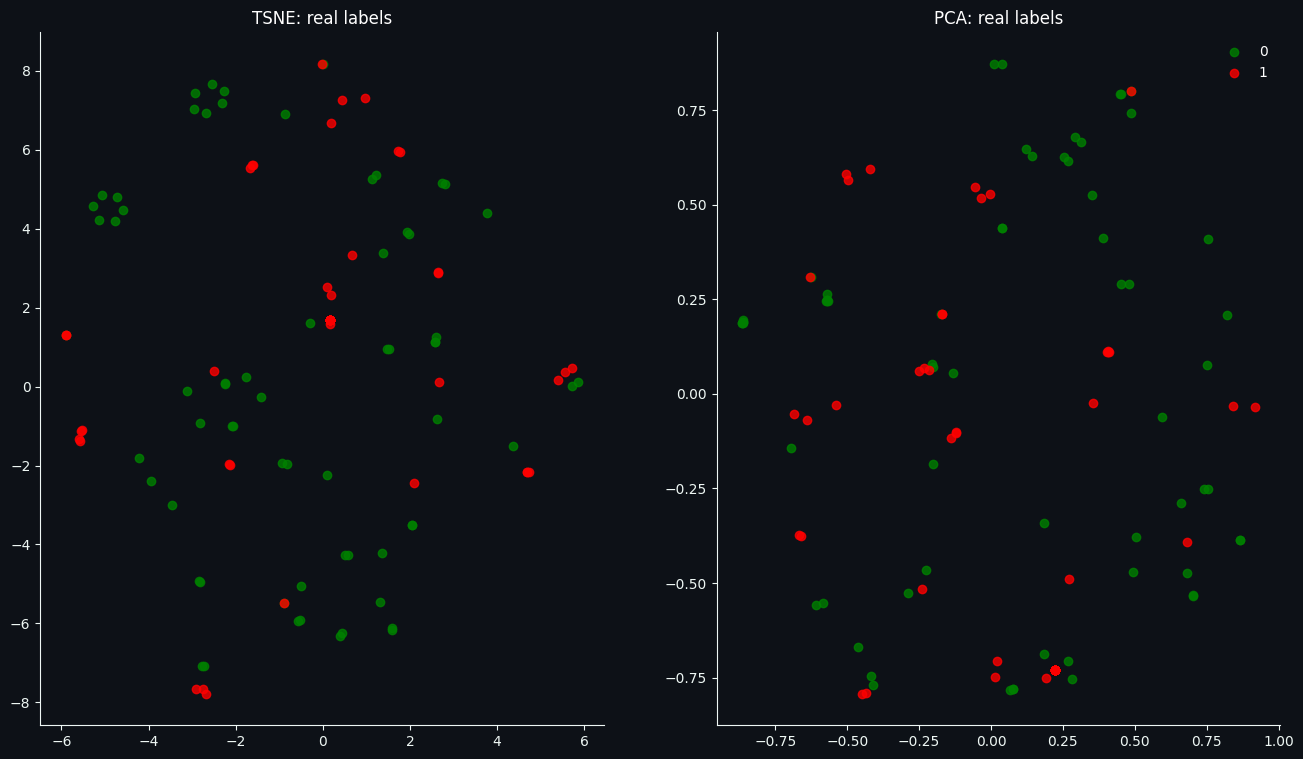

In [23]:
plot_2d(scaler.transform(main_reduced), target, "real labels")

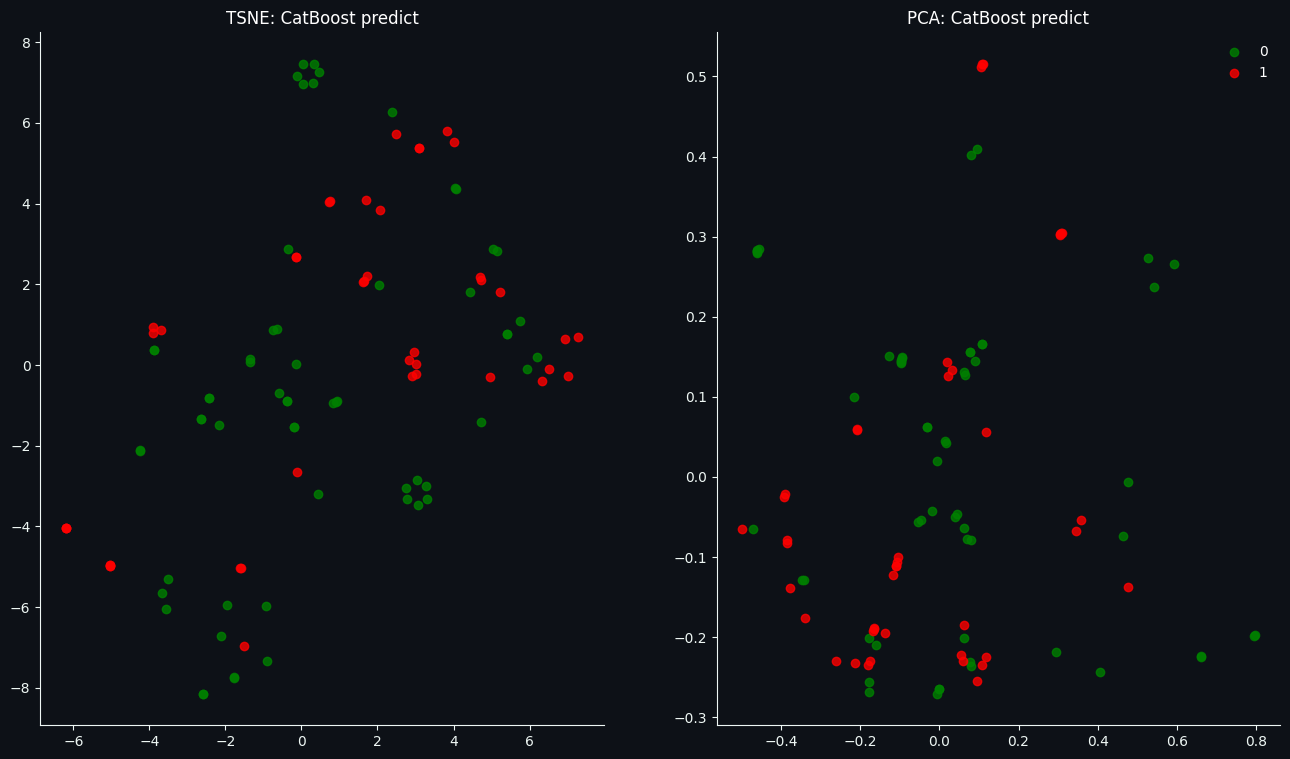

In [24]:
plot_2d(main_reduced, c_model.models["CatBoost"].predict(scaler.transform(main_reduced)), "CatBoost predict")

In [24]:
cat_ = np.array([*qmof_reduced, *main_reduced])

In [25]:
tsne = TSNE(n_components=2, random_state=0)
X_t = tsne.fit_transform(scaler.transform(cat_))
pca = PCA(n_components=2, random_state=0)
X_p = pca.fit_transform(scaler.transform(cat_))

In [26]:
xt_q = X_t[:qmof_reduced.shape[0]]
xp_q = X_p[:qmof_reduced.shape[0]]

xt_m = X_t[qmof_reduced.shape[0]:]
xp_m = X_p[qmof_reduced.shape[0]:]
pr_m = target.values.ravel()

In [27]:
pr_q = {name: c_model.models[name].predict_proba(qmof_reduced_scaled)[:,1] for name in c_model.models}

In [134]:
def colormap_plot(name):
    color = pr_q[name]

    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 9))

    ax1.scatter(xt_q[:, 0], xt_q[:, 1], alpha=0.2, c=color, cmap="seismic")

    ax1.scatter(xt_m[pr_m == 0, 0], xt_m[pr_m == 0, 1], marker='v', color='purple', s=50, label='no guest molecules (main)')
    ax1.scatter(xt_m[pr_m == 1, 0], xt_m[pr_m == 1, 1], marker='v', color='orange', s=50, label='guest molecules (main)')


    ax1.set_title(f"TSNE representation of predicted probability for {name}")
    map = ax2.scatter(xp_q[:, 0], xp_q[:, 1], marker='o', c=color, alpha=0.2, cmap='seismic')
    


    ax2.scatter(xp_m[pr_m == 0, 0], xp_m[pr_m == 0, 1], marker='v', color='purple', s=50, label='no guest molecules (main)')
    ax2.scatter(xp_m[pr_m == 1, 0], xp_m[pr_m == 1, 1], marker='v', color='orange', s=50,label='guest molecules (main)')

    ax2.set_title(f"PCA representation of predicted probability for {name}")
    ax2.legend()
    figure.colorbar(map)


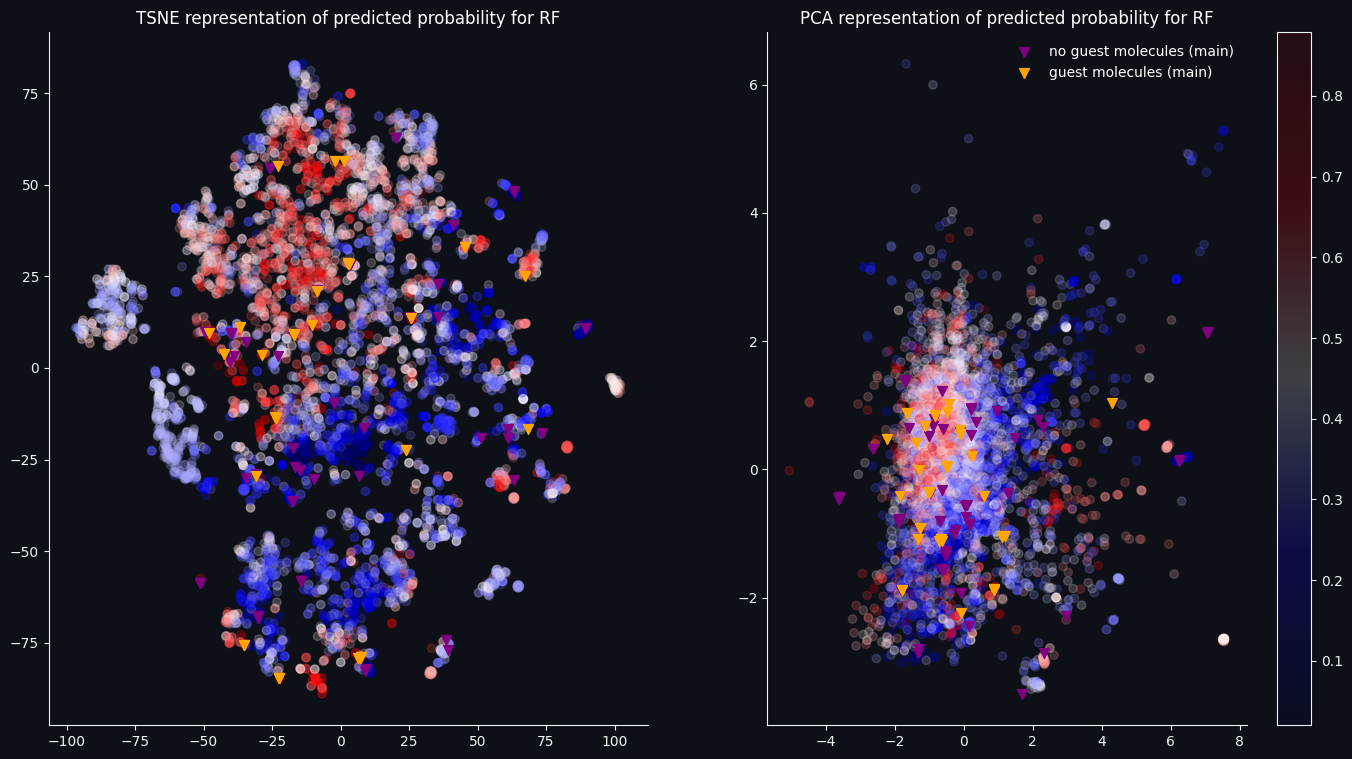

In [135]:
colormap_plot("RF")

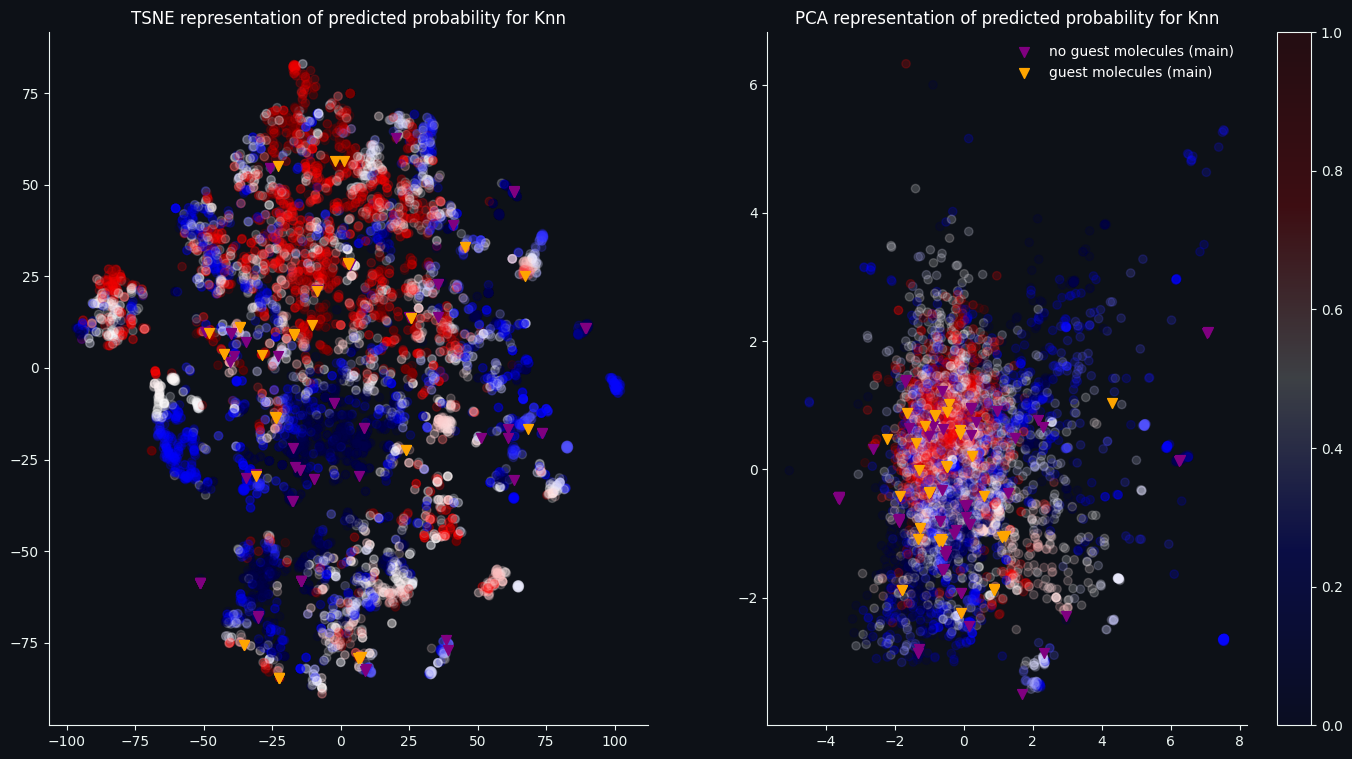

In [128]:
colormap_plot("Knn")

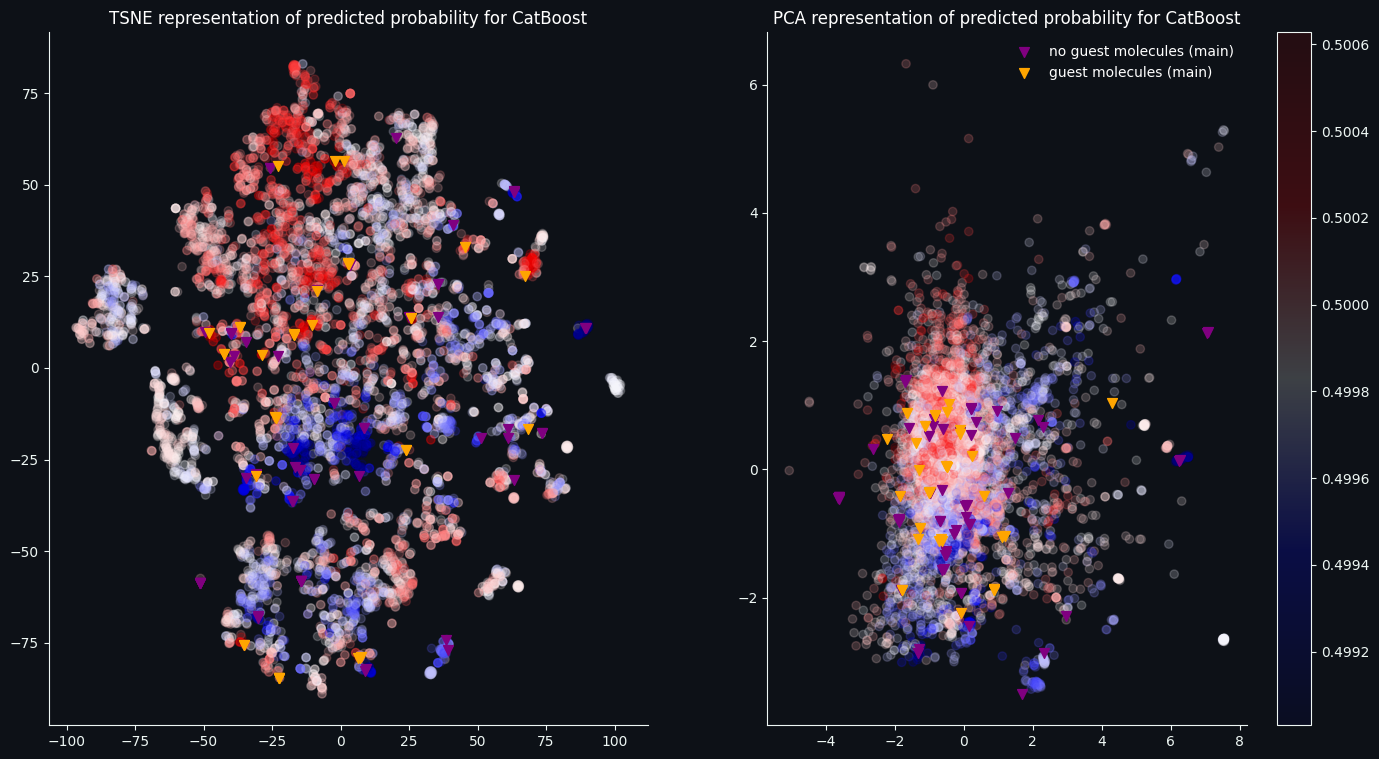

In [129]:
colormap_plot("CatBoost")

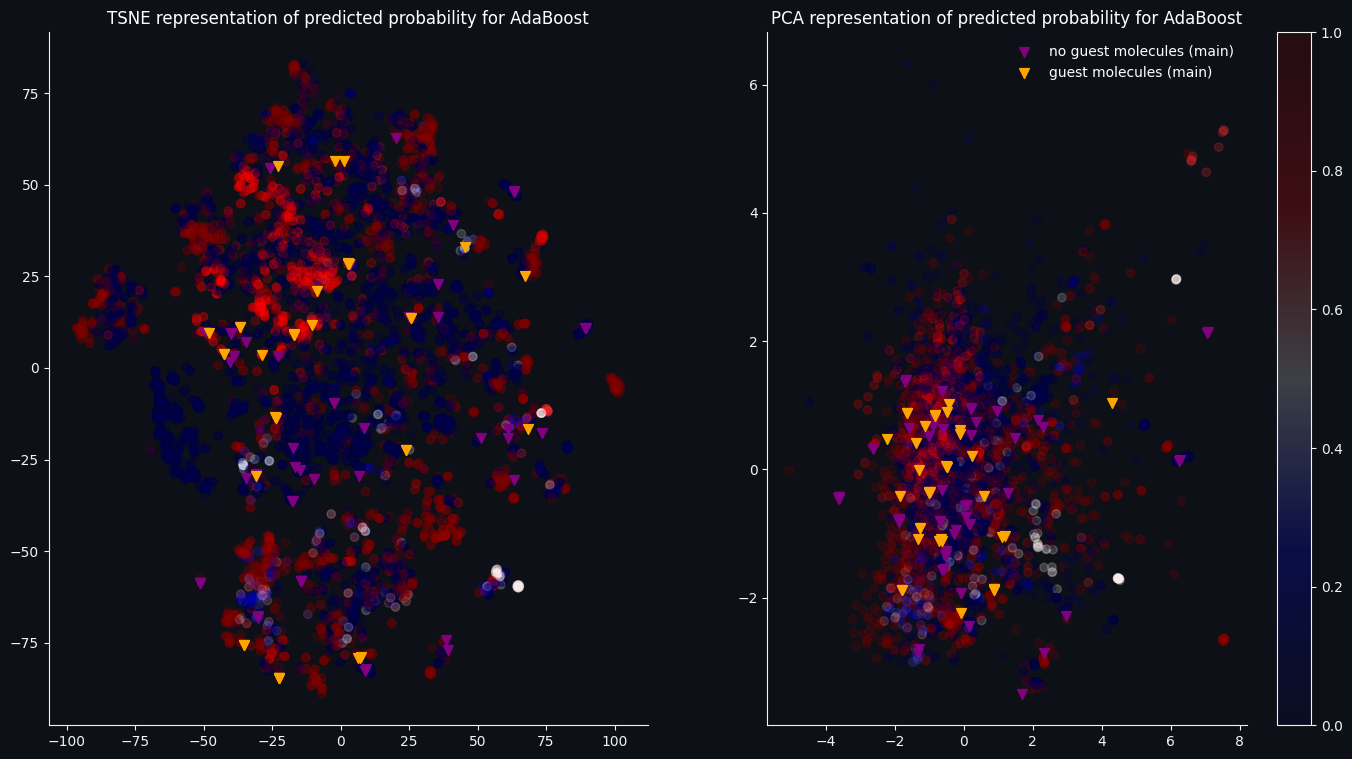

In [130]:
colormap_plot("AdaBoost")

In [131]:
import joblib

joblib.dump(reduce_model, "best/reduce_model.pkl")

joblib.dump(c_model, "best/c_model.pkl")

joblib.dump(res, "best/best_params.pkl")


['best/best_params.pkl']